In [1]:
import os
import sys

os.chdir('..')
sys.path.append('src')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter
from utilsOptuna import best_trial_scores_ML, best_trial_scores_DL
from utilsPlots import plot_density, plot_bars, plot_mutual_info_features_target
from sklearn.preprocessing import MultiLabelBinarizer

## Objective

This exercise aims to develop a model (machine learning or deep learning) to predict the engagement level generated by different tourist points of interest (POIs).

## Exploratory data analysis

Data contains 1,569 samples and available features could be splitted in three classes.

- **Engagement Features**: These columns contain information used to build the target feature that classifies POI engagement (**Likes**, **Dislikes**, **Bookmarks**, and **Visits**).

- **Metadata Features**: Columns that could be used as model inputs with simple transformations or encoding (**categories**, **tier**, **locationLon**, **locationLat**, **tags**, and **xps**).

- **Description Feature**: Text descriptions of POIs can be found in the **shortDescription** column. Text descriptions of the POIs are contained in the shortDescription column. As this feature cannot be processed alongside the metadata features, it will be analyzed separately.

- **Image Data**: The path to images associated with each POI (**main_image_path**).

The dataset is complete and free of duplicates.


In [3]:
poi_data = pd.read_csv("./data/poi_dataset.csv")

In [4]:
print(f'Number of samples: {poi_data.shape[0]}')
print(f'Number of features: {poi_data.shape[1]}')

Number of samples: 1569
Number of features: 14


In [5]:
# check data structure
poi_data.head().T

,0,1,2,3,4
id,4b36a3ed-3b28-4bc7-b975-1d48b586db03,e32b3603-a94f-49df-8b31-92445a86377c,0123a69b-13ac-4b65-a5d5-71a95560cff5,390d7d9e-e972-451c-b5e4-f494af15e788,023fc1bf-a1cd-4b9f-af78-48792ab1a294
name,Galería Fran Reus,Convento de San Plácido,Instituto Geológico y Minero de España,Margarita Gil Roësset,Museo del Traje. Centro de Investigación del P...
shortDescription,La Galería Fran Reus es un espacio dedicado a ...,"El Convento de San Plácido en Madrid, fundado ...","El Instituto Geológico y Minero de España, sit...","Margarita Gil Roësset, escultora y poetisa esp...","El Museo del Traje de Madrid, fundado en 2004,..."
categories,"['Escultura', 'Pintura']","['Patrimonio', 'Historia']","['Ciencia', 'Patrimonio']",['Cultura'],"['Patrimonio', 'Cultura']"
tier,1,1,2,1,1
locationLon,2.642262,-3.704467,-3.699694,-3.691228,-3.727822
locationLat,39.572694,40.423037,40.442045,40.427256,40.439665
tags,[],[],[],[],[]
xps,500,500,250,500,500
Visits,10009,10010,10015,10011,10020


In [6]:
# check NAs
poi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1569 non-null   object 
 1   name              1569 non-null   object 
 2   shortDescription  1569 non-null   object 
 3   categories        1569 non-null   object 
 4   tier              1569 non-null   int64  
 5   locationLon       1569 non-null   float64
 6   locationLat       1569 non-null   float64
 7   tags              1569 non-null   object 
 8   xps               1569 non-null   int64  
 9   Visits            1569 non-null   int64  
 10  Likes             1569 non-null   int64  
 11  Dislikes          1569 non-null   int64  
 12  Bookmarks         1569 non-null   int64  
 13  main_image_path   1569 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 171.7+ KB


### Engagement features.

All these features are quantitative variables. As shown in @fig-density-eng, features **Likes**, **Dislikes** and **Bookmarks** show a trimodal distribution. In all three distributions, two sharp peaks appear on the left side and a flat peak appears on the right side. **Visits** shows an unimodal distribution with positive skewness.

In [7]:
# Select features related to engagement
features = ['Visits', 'Likes', 'Dislikes', 'Bookmarks']
# Check for NAs
poi_data[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Visits     1569 non-null   int64
 1   Likes      1569 non-null   int64
 2   Dislikes   1569 non-null   int64
 3   Bookmarks  1569 non-null   int64
dtypes: int64(4)
memory usage: 49.2 KB


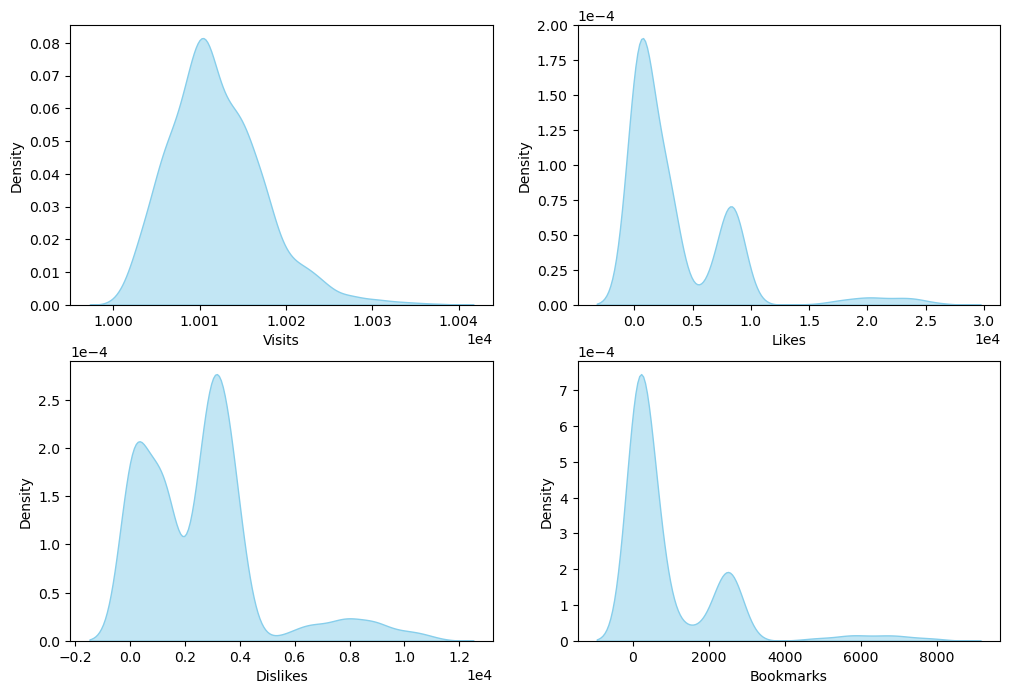

In [8]:
#| output: True
#| label: fig-density-eng
#| fig-cap: "Density plots for each engagement feature"
plot_density(poi_data, features, 2, 2)

In [9]:
poi_data[features].describe()

,Visits,Likes,Dislikes,Bookmarks
count,1569.000000,1569.000000,1569.000000,1569.000000
mean,10011.943276,3623.908222,2526.305927,973.261950
std,5.456808,4817.879374,2225.543360,1453.333948
min,10001.000000,100.000000,52.000000,50.000000
25%,10008.000000,464.000000,937.000000,116.000000
50%,10011.000000,1434.000000,2718.000000,306.000000
75%,10015.000000,6840.000000,3399.000000,1309.000000
max,10038.000000,26425.000000,10999.000000,8157.000000


It is reasonable to create a new feature from the difference between **Likes** and **Dislikes**. Negative values would indicate low engagement and positive values would suggest high engagement. This new feature show a multimodal distribution with several sharp peaks on the left and a flat peak on the right (see figure @fig-density-like-dislike)

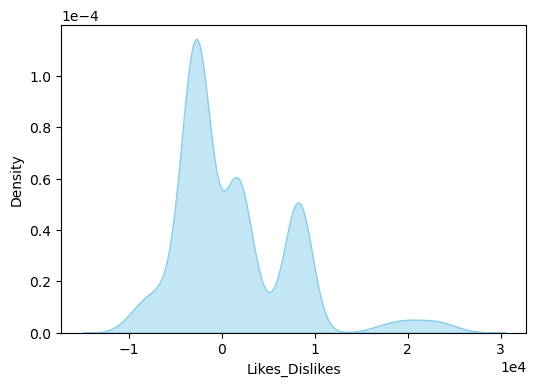

In [10]:
#| output: True
#| label: fig-density-like-dislike
#| fig-cap: "Density plots for new feature (Likes - Dislikes)"
poi_data['Likes_Dislikes'] = poi_data['Likes'] - poi_data['Dislikes']
plot_density(poi_data, ['Likes_Dislikes'], 1, 1)

Correlation analysis shows strong relationships between the features **Likes**, **Dislikes**, **Likes_Dislikes**, and **Bookmarks** (@fig-corr-mat-eng). **Visits** has low correlation with the other features.

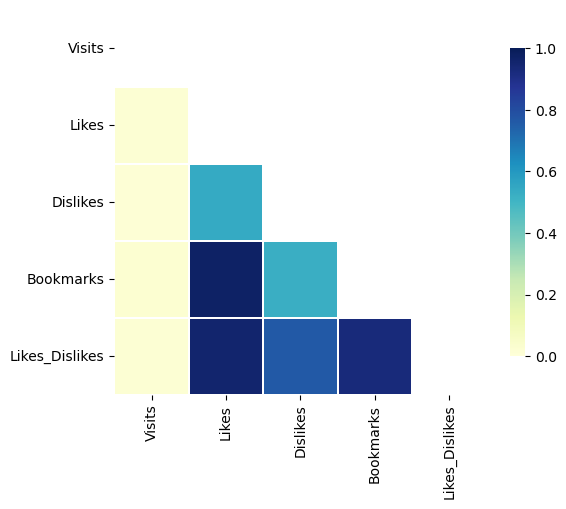

In [11]:
#| output: True
#| label: fig-corr-mat-eng
#| fig-cap: "PCC correlation between engagement features"
# Compute the correlation matrix for features related to engagement
corr = np.abs(poi_data[features + ['Likes_Dislikes']].corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 5))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

### Metadata features

The majority of samples (1,073) are assigned three labels in the **categories** feature, while only two POIs have none (@fig-num-cat). 


In [12]:
# Transform string to list of strings
poi_data['list_categories'] = poi_data['categories'].apply(eval)

# Unique categories
categories = set(cat for cats in poi_data['list_categories'] for cat in cats)
print(f'Number of unique categories: {len(categories)}')
print(f'Unique categories: {categories}')

# Randomly selection for categories
poi_data_random = poi_data.sample(n=5)
poi_data_random.index = list(range(1,6))
print('Some random categories features from data:')
for idx, categories_sample in poi_data_random['list_categories'].items():
  print(f'categories: {categories_sample}')

Number of unique categories: 12
Unique categories: {'Pintura', 'Cultura', 'Ocio', 'Naturaleza', 'Arquitectura', 'Ciencia', 'Historia', 'Gastronomía', 'Cine', 'Patrimonio', 'Misterio', 'Escultura'}
Some random categories features from data:
categories: ['Patrimonio', 'Cultura', 'Historia', 'Misterio']
categories: ['Cultura', 'Patrimonio', 'Historia', 'Misterio']
categories: ['Cultura', 'Escultura', 'Historia']
categories: ['Cultura', 'Patrimonio', 'Historia', 'Misterio']
categories: ['Escultura', 'Historia', 'Cultura']


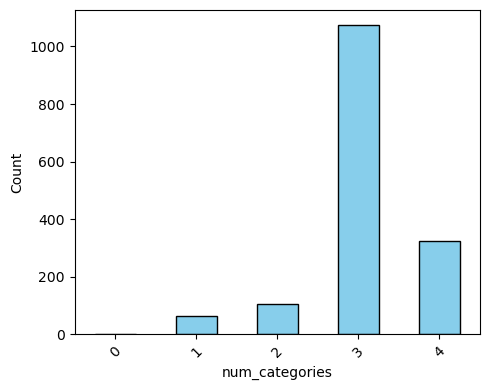

In [13]:
#| output: True
#| label: fig-num-cat
#| fig-cap: "Distribution of number of categories"
poi_data['num_categories'] = poi_data['list_categories'].apply(len)
plot_bars(poi_data, ['num_categories'], 1, 1)

In [14]:
poi_data['num_categories'].value_counts()

num_categories
3    1073
4     325
2     106
1      63
0       2
Name: count, dtype: int64

Across the dataset, 12 distinct labels are used. The most common are 'Historia' and 'Cultura,' each appearing in over half of all POIs (@fig-freq-cat). In contrast, labels such as 'Pintura,' 'Naturaleza', 'Cine' and 'Gastronomía' are relatively rare, each found in fewer than 5% of the records.

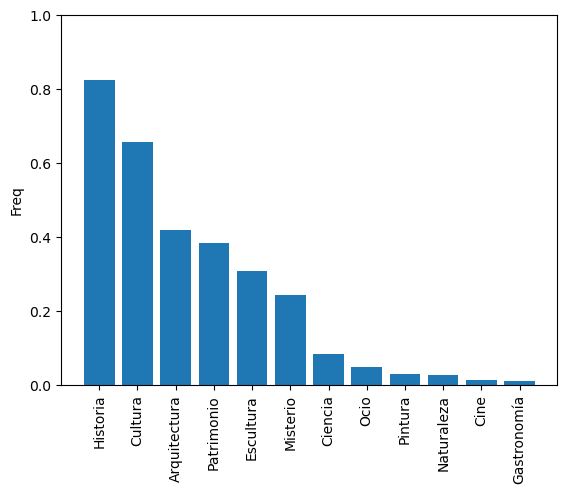

In [15]:
#| output: True
#| label: fig-freq-cat
#| fig-cap: "Frequencies for the categories"
# Frequencies for categories. Most common category is 'Historia' and least common category is 'Gastronomía'
counts = Counter(list(cat for cats in poi_data["list_categories"] for cat in cats))
sorted_items = [item for item, count in counts.most_common()]
sorted_counts = [count for item, count in counts.most_common()]
sorted_freq = list(map(lambda x: x/poi_data.shape[0], sorted_counts))

plt.bar(sorted_items, sorted_freq)
plt.xticks(rotation=90)
plt.ylim(0,1)
plt.ylabel("Freq")
plt.show()

The **tags** feature provides information similar to categories, but in greater detail. The dataset contains 2,935 unique tags, most of which are applied to more than eight POIs (@fig-num-tags). However, a significant number of tags are used infrequently, appearing in only a few POIs—sometimes just one.

In [16]:
# Number of unique tags
poi_data['list_tags'] = poi_data['tags'].apply(eval)
tags = set(tag for tags in poi_data['list_tags'] for tag in tags)
print(f'Number of unique tags: {len(tags)}')

# Randomly selection for tags
poi_data_random = poi_data.sample(n=5)
poi_data_random.index = list(range(1,6))
print('Some random tags features from data:')
for idx, tags in poi_data_random['tags'].items():
  print(f'tags: {tags}')

Number of unique tags: 2935
Some random tags features from data:
tags: ['Yacimientos', 'Tesoro', 'Señor de Sipán', 'Museos', 'Mochicas']
tags: ['Patrimonio', 'Fundador', 'Clasicismo francés', 'Instituciones educativas', 'Restauración', 'Igualdad de género', 'Educación', 'Madrid', 'Arquitectura', 'Historia educativa']
tags: ['Rehabilitación urbana', 'Patrimonio cultural', 'Arte', 'Bronce', 'Salvador fernández oliva', 'Curiosidad', 'Centro', 'Historia', 'Estatua', 'Palacio', 'Escultura', 'Madrid', 'Reflexión']
tags: ['Arquitectura', 'Cultura', 'Río Deza', 'Naturaleza', 'Restauración', 'Arte medieval', 'Historia', 'Galicia', 'Románico', 'Monasterio']
tags: ['Osarios', 'Momias', 'Leyenda', 'Huesos', 'Cripta']


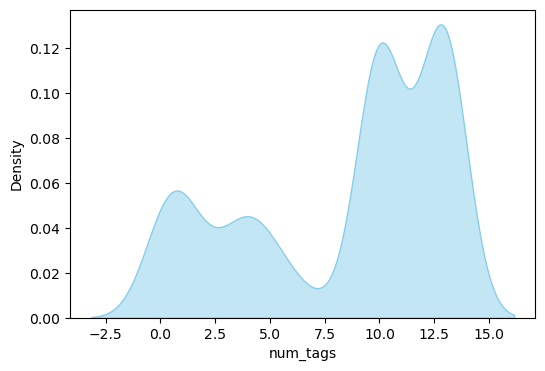

In [17]:
#| output: True
#| label: fig-num-tags
#| fig-cap: "Distribution of number of tags"
# Distribution number of tags each sample
poi_data['num_tags'] = poi_data['list_tags'].apply(len)
plot_density(poi_data, ['num_tags'], 1, 1)

In [18]:
poi_data['num_tags'].describe()

count    1569.000000
mean        8.483110
std         4.567507
min         0.000000
25%         4.000000
50%        10.000000
75%        13.000000
max        13.000000
Name: num_tags, dtype: float64

As shown in @fig-tier, the majority of POIs have a **tier** value of one. The number of POIs decreases as the **tier** increases to four, with a pronounced drop occurring between tiers two and three.

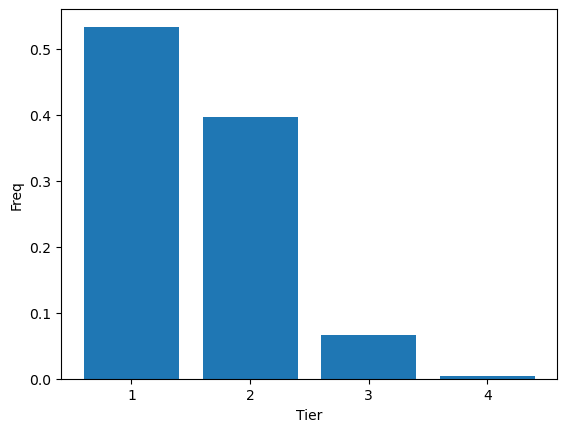

In [19]:
#| output: True
#| label: fig-tier
#| fig-cap: "Frequencies for feature tier"
# how tier is distributed
tier_freq = list(poi_data['tier'].value_counts().apply(lambda x: x/poi_data.shape[0]))
tier = [str(item) for item in list(poi_data['tier'].value_counts().index)]

plt.bar(tier, tier_freq)
plt.xlabel('Tier')
plt.ylabel('Freq')
plt.show()


The features locationLon and locationLat exhibit distributions with sharp peaks at 0 and 40, respectively (@fig-quant). This pattern suggests that most POIs are concentrated within a small geographic region. Meanwhile, the xps feature displays a multimodal distribution characterized by a sharp peak centered at 1000.

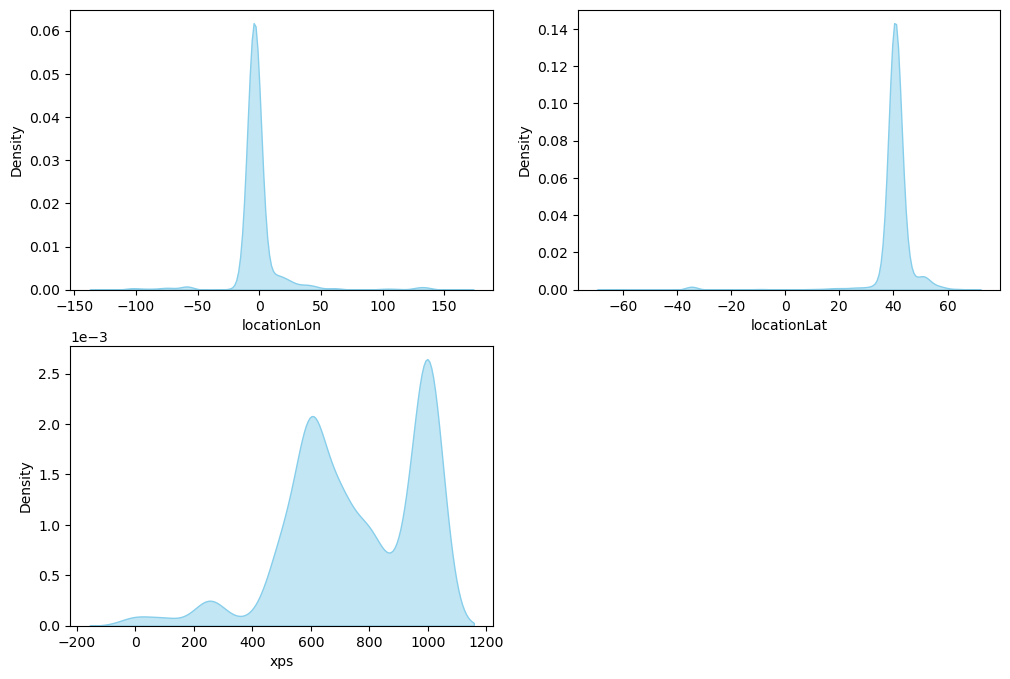

In [20]:
#| output: True
#| label: fig-quant
#| fig-cap: "Distribution for features locationLon, locationLat and xps"
# density plots for quantitative features
plot_density(poi_data, ['locationLon','locationLat','xps'], 2, 2)

In [21]:
poi_data[['locationLon','locationLat','xps']].describe()

,locationLon,locationLat,xps
count,1569.000000,1569.000000,1569.000000
mean,-1.132337,39.900141,750.382409
std,22.733401,9.662134,228.319854
min,-121.951049,-62.940930,0.000000
25%,-3.725292,40.411754,600.000000
50%,-3.699140,40.421738,700.000000
75%,-3.673348,40.472458,1000.000000
max,158.333118,65.706572,1000.000000


### Description feature.

A short text describing the POIs is available at **shortDescription** feature. It could be in the range from two words to a maximum of 89 words (@fig-short-desc). 

In [22]:
# analysis for shortDescription feature
poi_data_random = poi_data.sample(n=5)
for _, shortDescription in poi_data_random['shortDescription'].items():
  print(f'shortDescription: {shortDescription}')

shortDescription: Visita el osario de Sedlec, un asombroso arte funerario hecho de huesos humanos. ¡Un destino único cerca de Praga!
shortDescription: ¡Descubre el Edificio Bankunión! Arquitectura moderna y sede del Parlamento Europeo y Embajada de Irlanda en Madrid.
shortDescription: ¡Descubre el Monumento a los Saineteros! Un tributo a la rica tradición teatral madrileña y su vibrante cultura.
shortDescription: ¡Descubre el Palacio del duque del Infantado! Un viaje en el tiempo a la nobleza del siglo XVII en Madrid.
shortDescription: Descubre la escultura de Fruela I, un testimonio de la rica herencia cultural y artística de España.


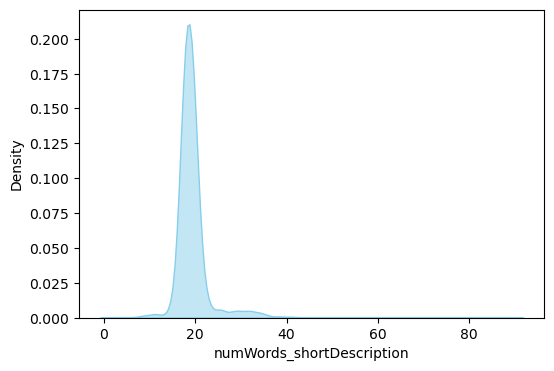

In [23]:
#| output: True
#| label: fig-short-desc
#| fig-cap: "Distribution for number of words in shortDescription"
poi_data['numWords_shortDescription'] = poi_data['shortDescription'].apply(lambda x: len(x.split()))
plot_density(poi_data, ['numWords_shortDescription'], 1, 1)

In [24]:
poi_data['numWords_shortDescription'].describe()

count    1569.000000
mean       19.316125
std         4.087781
min         2.000000
25%        18.000000
50%        19.000000
75%        20.000000
max        89.000000
Name: numWords_shortDescription, dtype: float64

### Image feature.

@fig-random-images displays a random sample of images. The distribution of the standard deviation (SD) of pixel values for each channel was analyzed and found to be approximately normal. However, some images exhibit very low SD values (@fig-dens-channels). Upon inspection, these were found to be 'empty' images, appearing almost entirely white (@fig-na-image).

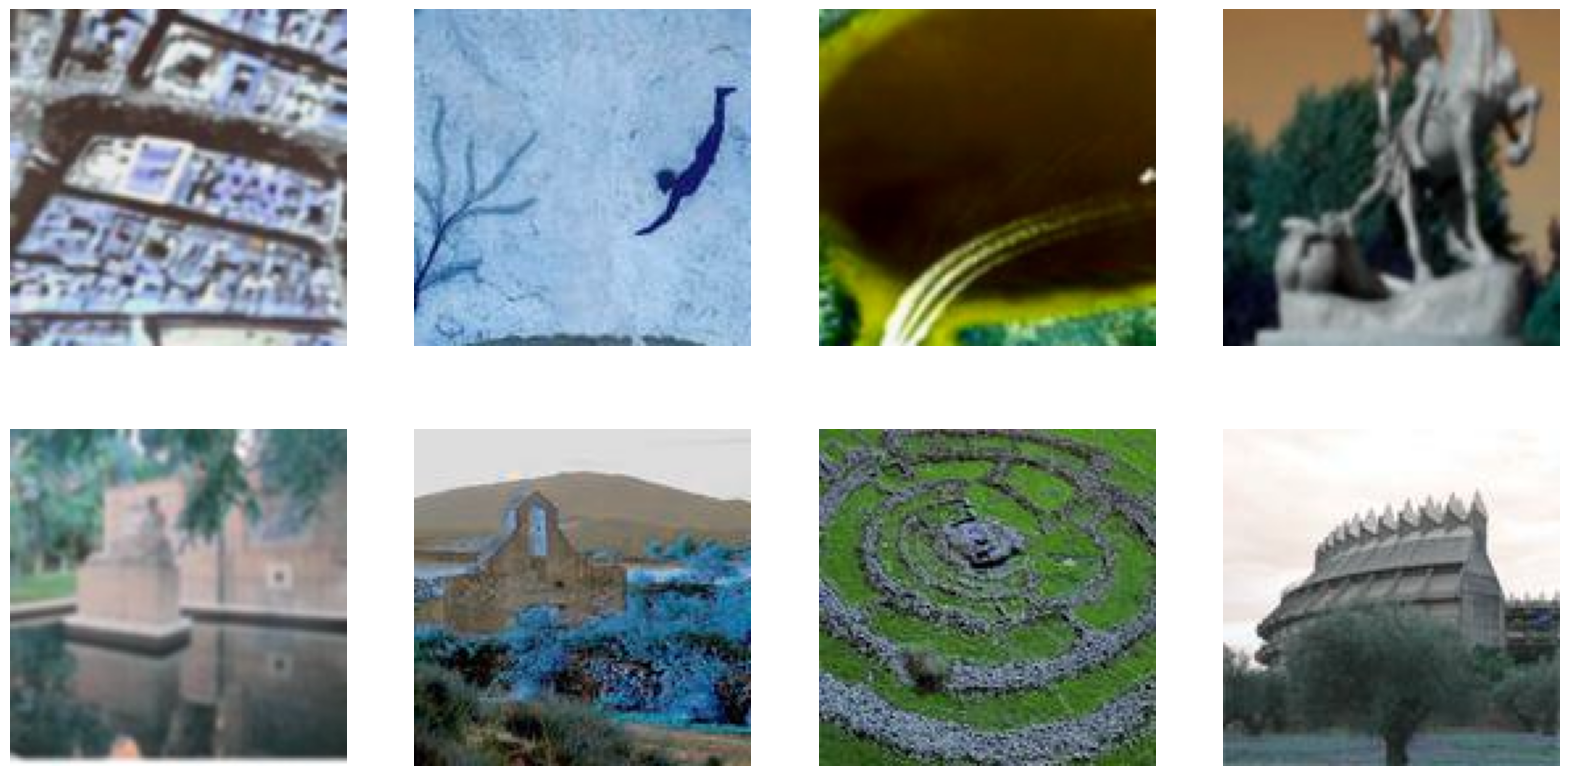

In [25]:
#| output: True
#| label: fig-random-images
#| fig-cap: "Example of images of POIs"
# plot random images
poi_data_random = poi_data.sample(n=8)
poi_data_random.index = list(range(1,9))

plt.figure(figsize=(20,10))
for idx, main_img_path in poi_data_random['main_image_path'].items():
  img_path = 'data/' + main_img_path
  image = cv2.imread(img_path)
  plt.subplot(2,4,idx)
  plt.imshow(image)
  plt.axis('off')
plt.show()

In [26]:
# read images and calculate sd for each channel
list_sd_images = []
for idx, main_img_path in poi_data['main_image_path'].items():
  img_path = 'data/' + main_img_path
  image = cv2.imread(img_path)
  list_sd_images.append(np.std(image, axis=(0,1)))
np_sd_images = np.vstack(list_sd_images)

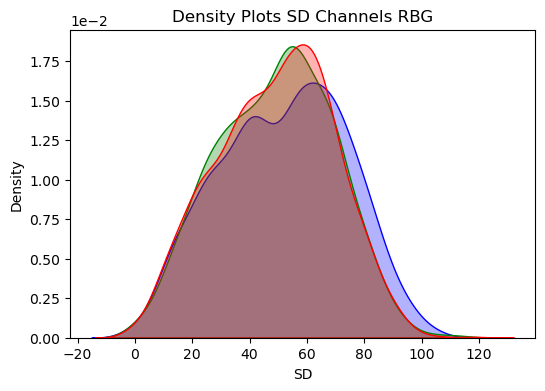

In [27]:
#| output: True
#| label: fig-dens-channels
#| fig-cap: "Distribution of SD for each channel of the images"
# for each channel a density plot is show
plt.figure(figsize=(6, 4))

sns.kdeplot(np_sd_images[:, 0], color='blue', fill=True, alpha = 0.3)
sns.kdeplot(np_sd_images[:, 1], color='green', fill=True, alpha = 0.3)
sns.kdeplot(np_sd_images[:, 2], color='red', fill=True, alpha = 0.3)
plt.title("Density Plots SD Channels RBG")
plt.xlabel('SD')
plt.ylabel('Density')
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2, 4))

plt.show()

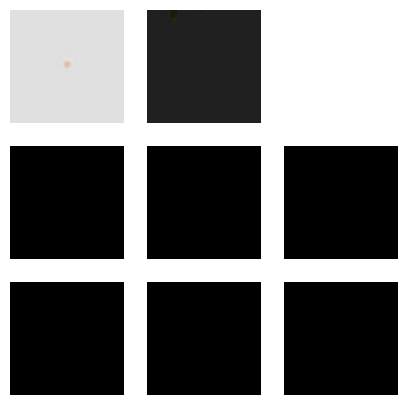

In [28]:
#| output: True
#| label: fig-na-image
#| fig-cap: "Example of images without any information"
# To check for 'NA' in image, a cut-off is used for SD (< 1)
idx_image_selection = np.where(np.any(np_sd_images < 1, axis = 1))[0]

poi_data_selection = poi_data.iloc[idx_image_selection]
poi_data_selection.index = list(range(1,len(idx_image_selection)+1))

plt.figure(figsize=(5,5))
for idx, main_img_path in poi_data_selection['main_image_path'].items():
  img_path = 'data/' + main_img_path
  image = cv2.imread(img_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.subplot(3,3,idx)
  plt.imshow(image)
  plt.axis('off')
plt.show()

## Target feature

Both the Bookmarks and Likes_Dislikes features are reliable indicators of user engagement. They exhibit a high correlation, so either would be a suitable choice for the analysis.

In this study, Likes_Dislikes was selected because it allows for a straightforward separation of samples into low and high engagement based on the sign of its value. Samples with negative values are classified as low engagement POIs, while those with positive values are classified as high engagement POIs. Using this threshold, 827 POIs were identified as low engagement and 742 as high engagement.

The Visits feature could be used to normalize Likes_Dislikes, as shown in @fig-eng, to create an engagement rate metric.

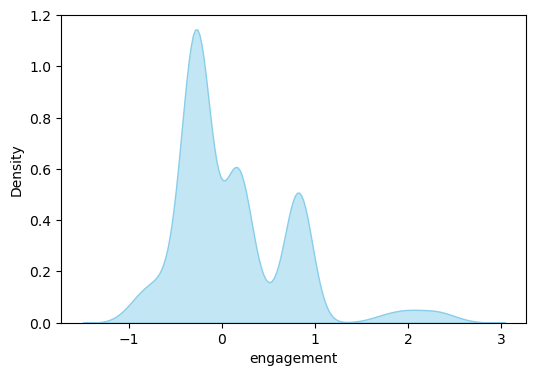

In [29]:
#| output: True
#| label: fig-eng
#| fig-cap: "Density plots for each engagement feature"
poi_data['engagement'] = poi_data['Likes_Dislikes']/poi_data['Visits']
plot_density(poi_data, ['engagement'], 1, 1)

In [30]:
poi_data['target'] = poi_data['engagement'].apply(lambda x: 1 if x > 0 else 0)
poi_data['target'].value_counts()

target
0    827
1    742
Name: count, dtype: int64

## Mutual information between features and target

Of the dummy variables created from the 'categories' feature, 'Escultura' is by far the most strongly associated with the target (see @fig-mi). Other categorical dummy variables with notable association include 'Arquitectura', 'Patrimonio', 'Ocio', 'Misterio', and 'Ciencia'.

Regarding the other features, num_tags and locationLon demonstrate the highest association with the target, while xps and tier also show a measurable relationship.

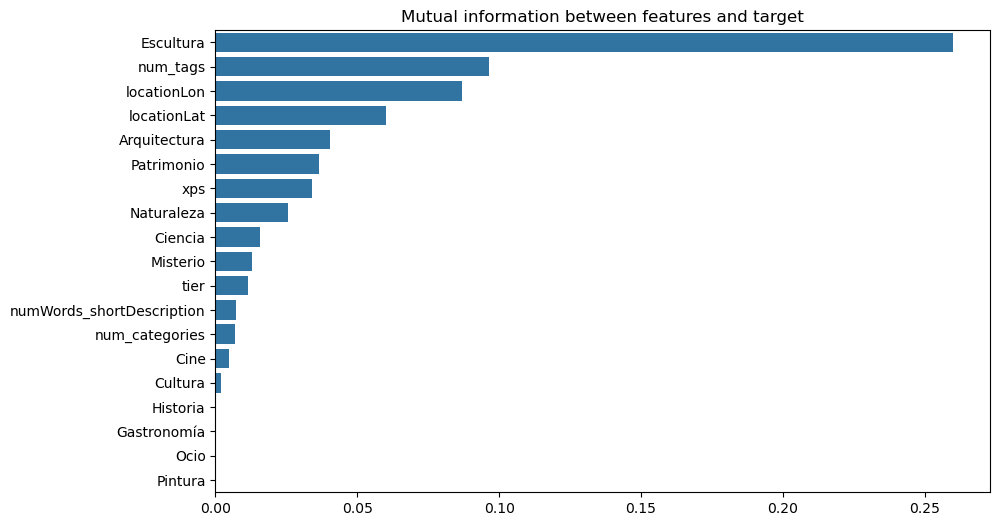

In [31]:
#| output: True
#| label: fig-mi
#| fig-cap: "Mutual information between features and target"

features = ['num_tags', 'locationLon', 'locationLat', 'xps', 'numWords_shortDescription','num_categories', 'tier']
df_features = poi_data[features]
mlb = MultiLabelBinarizer()
binary_tags = mlb.fit_transform(poi_data['list_categories'])
df_categories = pd.DataFrame(binary_tags, columns=mlb.classes_)
df = pd.concat([df_features, df_categories], axis = 1)

target = poi_data['engagement'].apply(lambda x: 1 if x > 0 else 0)

plot_mutual_info_features_target(df, target)

## Images and engagement relationship

Images with extreme engagement values are displayed to uncover insights about the relationship between engagement and visual content (see @fig-high-image and @fig-low-image). With these examples, a clear association between images and engagement is not demostrated.

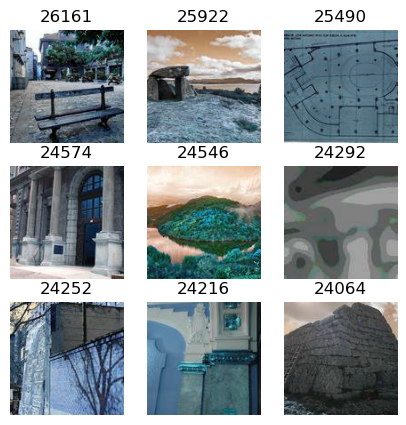

In [47]:
#| output: True
#| label: fig-high-image
#| fig-cap: "Images for POIs with higher engagement"
top_n = 9
poi_data_high_engagement = poi_data.sort_values('Likes_Dislikes', ascending = False).head(top_n)
poi_data_high_engagement.index = list(range(1,top_n+1))

plt.figure(figsize=(5,5))
for idx, row in poi_data_high_engagement.iterrows():
  img_path = 'data/' + row['main_image_path']
  image = cv2.imread(img_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.subplot(3,3,idx)
  plt.imshow(image)
  plt.axis('off')
  plt.title(row['Likes_Dislikes'])
plt.show()

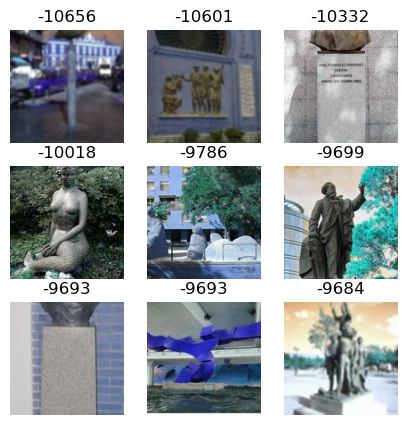

In [ ]:
#| output: True
#| label: fig-low-image
#| fig-cap: "Images for POIs with lower engagement"
bottom_n = 9
poi_data_low_engagement = poi_data.sort_values('Likes_Dislikes').head(bottom_n)
poi_data_low_engagement.index = list(range(1,bottom_n+1))

plt.figure(figsize=(5,5))
for idx, row in poi_data_low_engagement.iterrows():
  img_path = 'data/' + row['main_image_path']
  image = cv2.imread(img_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.subplot(3,3,idx)
  plt.imshow(image)
  plt.axis('off')
  plt.title(row['Likes_Dislikes'])
plt.show()

## Optimization strategy

Hyperparameter tuning was performed using Optuna framework exploring each model's parameter space to identify optimal configurations that maximize predictive performance using TPE algorithm. Several scores were calculated but F1-score was used to drive hyperparameter optimization.

## Machine learning models

Machine learning models trained on metadata features consistently achieved an F1-score of ~0.8. This performance was characterized by high sensitivity (>0.97) in identifying high-engagement POIs but low precision (<0.68), leading to a substantial number of false positives.

In [34]:
#| output: asis

storage = 'sqlite:///optuna/optuna_DL_exercise.db'
list_results = ['train_f1_score', 'test_f1_score', 'test_precision', 'test_sensitivity']
list_studies = {'name_model': ['MML_logreg_metadata1', 'MML_randomforest_metadata1', 'MML_xgboost_metadata1'],
                'Model': ['Log Regression', 'Random Forest', 'XGBoost']}
df_studies = pd.DataFrame(list_studies)
results = best_trial_scores_ML(storage, list_results, list_studies['name_model'])
df = pd.DataFrame(results, columns = ['name_model', 'Train score', 'Valid score', 'Precision', 'Sensitivity'])

df_final = df_studies.merge(df, on='name_model').drop(['name_model'], axis=1)

print(df_final.to_markdown(index=False))

| Model          |   Train score |   Valid score |   Precision |   Sensitivity |
|:---------------|--------------:|--------------:|------------:|--------------:|
| Log Regression |         0.805 |         0.796 |       0.675 |         0.971 |
| Random Forest  |         0.807 |         0.807 |       0.677 |         1     |
| XGBoost        |         0.809 |         0.803 |       0.675 |         0.992 |


## Deep learning models

Multiple deep learning models were developed and assessed using different combinations of metadata, images, and embeddings.

**FCNN Shallow**: A shallow, fully connected neural network that uses metadata as input.

**FCNN PCA**: fully connected neural network with progressive compression architecture. It uses embeddings from the shortDescription field as input.

**ResNet18 Pre**: A standard ResNet18 model with pretrained weights, using images as input. All layers are frozen.

**ResNet18 Layer4**: A ResNet18 model with pretrained weights, fine-tuned for the task. The weights of layer4 are unfrozen and optimized, while earlier layers remain frozen. The model uses images as input.

**Multi Modal Pre**: Multi-modal neuronal network with three input branches.

- Image Branch: Processes images through a ResNet18 backbone.

- Text Branch: Processes shortDescription embeddings through a fully connected network with a progressive compression architecture.

- Metadata Branch: Directly incorporates metadata features.

The outputs from all three branches are concatenated and passed through a final classifier.

**Multi Modal Layer4**: Same as above model but with optimization of weights of layer 4.

In [35]:
#| output: asis

storage = 'sqlite:///optuna/optuna_DL_exercise.db'
list_results = ['precision', 'sensitivity']
list_studies = {'name_model': ['MDL_fcnn_shallow_metadata1', 'MDL_fcnn_pca_embeddings1', 'MDL_resnet18_pretrain_images1', 'MDL_resnet18_layer4_images1', 'MDL_mmodal3_pre_img1_meta1_emb1','MDL_mmodal3_layer4_img1_meta1_emb1'],
                'Model': ['FCNN Shallow', 'FCNN PCA', 'ResNet18 Pre', 'ResNet18 Layer4', 'Multi Modal Pre', 'Multi Modal Layer4']}
df_studies = pd.DataFrame(list_studies)
results = best_trial_scores_DL(storage, list_results, list_studies['name_model'])
df = pd.DataFrame(results, columns = ['name_model', 'Train score', 'Valid score', 'Precision', 'Sensitivity'])

df_final = df_studies.merge(df, on='name_model').drop(['name_model'], axis=1)

print(df_final.to_markdown(index=False))

| Model              |   Train score |   Valid score |   Precision |   Sensitivity |
|:-------------------|--------------:|--------------:|------------:|--------------:|
| FCNN Shallow       |         0.748 |         0.79  |       0.669 |         0.966 |
| FCNN PCA           |         0.309 |         0.643 |       0.474 |         1     |
| ResNet18 Pre       |         0.714 |         0.8   |       0.726 |         0.891 |
| ResNet18 Layer4    |         0.967 |         0.851 |       0.862 |         0.84  |
| Multi Modal Pre    |         0.892 |         0.878 |       0.91  |         0.849 |
| Multi Modal Layer4 |         0.874 |         0.849 |       0.849 |         0.849 |


**FCNN Shallow** and **ResNet18 Pre** yield results comparable to traditional Machine Learning models. Using the pre-trained ResNet18 via transfer learning achieves a balance between precision and sensitivity, improving precision at the cost of some sensitivity reduction. **FCNN_pca** demonstrates poor performance, inferior to all ML models.

**ResNet18 Layer4**, **Multi Modal Pre**, and **Multi Modal Layer4** models achieve significantly higher F1-scores, all exceeding 0.84. However, **ResNet18 Layer4** shows substantial overfitting, with a high training F1-score that doesn't generalize to validation. In contrast, both Multi Modal models show consistent performance across training and validation sets. **Multi Modal Pre** delivers the best overall results, with precision exceeding 0.9.

The choice between top-performing models depends on the specific objective. For higher precision in detecting high-engagement POIs, **Multi Modal Pre** is recommended. When higher sensitivity is required for this task, **Random Forest** becomes the more suitable choice.

## Final models

Based on the results above, two models were trained using 80% of the dataset, with validation performed on the remaining 20%. The results are presented below.

### Random forest model

The Random Forest model successfully identifies all high-engagement POIs (Sensitivity = 1.0), but at the cost of including some false positives, resulting in a Precision of 0.71 (see confusion matrix @fig-cmrf). This trade-off yields an F1-score of 0.71 on the testing dataset.

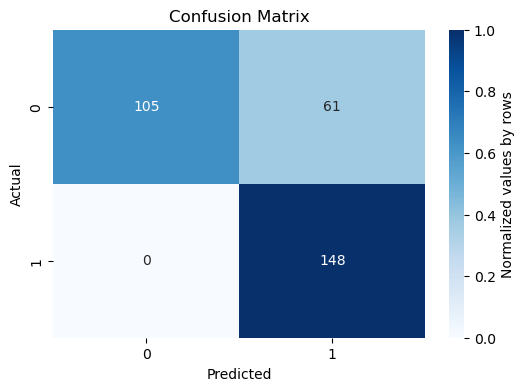

In [36]:
#| output: True
#| label: fig-cmrf
#| fig-cap: "Confusion matrix for random forest model"
import numpy as np
from utilsModel import TrainModels
from utilsPlots import confusion_matrix_plot

models_trained = TrainModels()
model_name = "MML_randomforest_metadata1_T3"
info = models_trained.list_of_models[model_name]

cm = np.array(info['scores']['confusion_matrix'][0], dtype=int)

confusion_matrix_plot(cm)


### Multi modal model with pretrained weights (Multi Modal Pre)

This model demonstrates a strong balance between sensitivity and precision, with values of 0.88 and 0.84 respectively (see confusion matrix in @fig-cmmm). The resulting F1-score is 0.86.

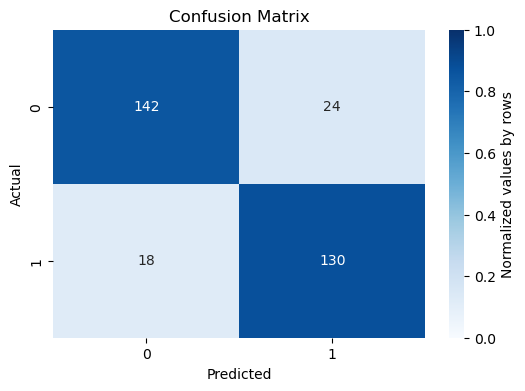

In [37]:
#| output: True
#| label: fig-cmmm
#| fig-cap: "Confusion matrix for multi modal model"
import numpy as np
from utilsModel import TrainModels
from utilsPlots import confusion_matrix_plot

models_trained = TrainModels()
model_name = "MDL_mmodal3_pre_img1_meta1_emb1_T14"
info = models_trained.list_of_models[model_name]

cm = np.array(info['scores']['confusion_matrix'][0], dtype=int)

confusion_matrix_plot(cm)
